In [1]:
import pickle
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns',500)
import matplotlib.pyplot as plt

In [186]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve,GroupKFold
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score,classification_report, precision_recall_curve, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier)
from sklearn.svm import SVC


In [30]:
def get_class_bounds(y, y_pred, N=5, class0_fraction=-1):
    """
    Find boundary values for y_pred to match the known y class percentiles.
    Returns N-1 boundaries in y_pred values that separate y_pred
    into N classes (0, 1, 2, ..., N-1) with same percentiles as y has.
    Can adjust the fraction in Class 0 by the given factor (>=0), if desired. 
    """
    ysort = np.sort(y)
    predsort = np.sort(y_pred)
    bounds = []
    for ibound in range(N-1):
        iy = len(ysort[ysort <= ibound])
        # adjust the number of class 0 predictions?
        if (ibound == 0) and (class0_fraction >= 0.0) :
            iy = int(class0_fraction * iy)
        bounds.append(predsort[iy])
    return bounds

def assign_class(y_pred, boundaries):
    """
    Given class boundaries in y_pred units, output integer class values
    """
    y_classes = np.zeros(len(y_pred))
    for iclass, bound in enumerate(boundaries):
        y_classes[y_pred >= bound] = iclass + 1
    return y_classes.astype(int)

In [42]:
#Read the train and test cleaned data with engineered features
train_copy_df = pd.read_csv('train_complete.csv')
test_copy_df = pd.read_csv('test_complete.csv')

In [43]:
drop_cols = ['AdoptionSpeed','Description','Name','PetID','Quantity']

In [44]:
#Drop description, petid, name and prepare features, response and test set
y = train_copy_df['AdoptionSpeed']
X = train_copy_df.drop(drop_cols,axis=1)
test_X = test_copy_df.drop(drop_cols, axis=1)
#test_X = test_X.values
print(X.shape,y.shape,test_X.shape)

(14993, 57) (14993,) (3948, 57)


In [201]:
#Add M1_RF and M2_XGB features in both train and test features set
train_copy_df['M1_RF'] = np.NaN
train_copy_df['M2_XGB'] = np.NaN
train_copy_df['M3_SVM'] = np.NaN
train_copy_df['M4_EXTC'] = np.NaN
train_copy_df['M5_GBM'] = np.NaN
test_copy_df['M1_RF'] = np.NaN
test_copy_df['M2_XGB'] = np.NaN
test_copy_df['M3_SVM'] = np.NaN
test_copy_df['M4_EXTC'] = np.NaN
test_copy_df['M5_GBM'] = np.NaN

In [209]:
SVC?

In [210]:
# Divide the training data into k-folds, k=4 here.
splits = list(StratifiedKFold(n_splits=4, shuffle=True, random_state=1812).split(X, y))

# Choose and initialize a model.
n_jobs=8
clf_XGB = XGBClassifier(max_depth=7,n_estimators=250,n_jobs=n_jobs)
clf_RF = RandomForestClassifier(bootstrap=True, criterion = 'gini', max_depth=80,
                             max_features='auto', min_samples_leaf=5,
                             min_samples_split=5, n_estimators=200,n_jobs=n_jobs)
clf_SVM = SVC(C=1.0,kernel='rbf',probability=True)
clf_EXTC = ExtraTreesClassifier(n_estimators=250,max_depth=80,n_jobs=n_jobs)
clf_GBM = GradientBoostingClassifier(learning_rate=0.1,n_estimators=200)

models = [('XGB',clf_XGB)
          ,('RF',clf_RF)
          ,('EXTC',clf_EXTC)
          ,('GBM',clf_GBM)
          #,('SVM',clf_SVM)
         ]

In [211]:
# Define what will be the final predicted train and test values


for (classfier_name,clf) in models:
    print('Running Model: {}'.format(classfier_name))
    train_meta = np.zeros(y.shape)
    test_meta = np.zeros(test_X.shape[0])
    for idx, (train_idx, valid_idx) in enumerate(splits): 
        X_train = X.iloc[train_idx]
        y_train = y[train_idx]
        X_val = X.iloc[valid_idx]
        y_val = y[valid_idx]
        
        # Fit the model
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        y_probs = clf.predict_proba(X_val)
        print("Fold {}: accuracy = {:.1f}%, kappa = {:.4f}  (no boundary adjustment)".format(idx,
                                100.0*accuracy_score(y_val, y_pred),     
                                cohen_kappa_score(y_val, y_pred, weights='quadratic')))
        
        class_vals = clf.classes_.copy()
        
        class_vals[0] = -1
        y_floats = [sum(y_probs[ix]*class_vals) for ix in range(len(y_probs[:,0]))]
               
        train_meta[valid_idx] = y_floats
            
        test_probs = clf.predict_proba(test_X)
        test_meta += np.array([sum(test_probs[ix]*class_vals) for
                               ix in range(len(test_probs[:,0]))]) / len(splits)
    train_y = y
    df_train = train_copy_df
    # Save values of kappa, MSE, and accuracy vs the class0 fraction
    kappas = []
    mses = []
    accurs = []
    # fractions to try... (could go larger than 1 if desired.)
    cl0fracs = np.array(np.arange(0.01,1.001,0.01))
    for cl0frac in cl0fracs:
        boundaries = get_class_bounds(train_y, train_meta, class0_fraction=cl0frac)
        train_meta_ints = assign_class(train_meta, boundaries)
        kappa = cohen_kappa_score(df_train['AdoptionSpeed'], train_meta_ints, weights='quadratic')
        kappas.append(kappa)
        mse = mean_squared_error(df_train['AdoptionSpeed'], train_meta_ints)
        mses.append(mse)
        accur = accuracy_score(df_train['AdoptionSpeed'], train_meta_ints)
        accurs.append(accur)

    # Use the class0 fraction that gives the highest training kappa
    ifmax = np.array(kappas).argmax()
    cl0frac = cl0fracs[ifmax]

    print("Best kappa for class0 fraction = {:.4f}".format(cl0frac))
    boundaries = get_class_bounds(train_y, train_meta, class0_fraction=cl0frac)
    train_meta_ints = assign_class(train_meta, boundaries)
    test_meta_ints = assign_class(test_meta, boundaries)
    if classfier_name == 'XGB':
        train_copy_df['M2_XGB'] = train_meta_ints
        test_copy_df['M2_XGB'] = test_meta_ints
    elif classfier_name == 'RF':
        train_copy_df['M1_RF'] = train_meta_ints
        test_copy_df['M1_RF'] = test_meta_ints
    elif classfier_name == 'SVM':
        train_copy_df['M3_SVM'] = train_meta_ints
        test_copy_df['M3_SVM'] = test_meta_ints
    elif classfier_name == 'EXTC':
        train_copy_df['M4_EXTC'] = train_meta_ints
        test_copy_df['M4_EXTC'] = test_meta_ints
    elif classfier_name == 'GBM':
        train_copy_df['M5_GBM'] = train_meta_ints
        test_copy_df['M5_GBM'] = test_meta_ints
    
    kappa = cohen_kappa_score(train_y, train_meta_ints, weights='quadratic')
    print("kappa = {:.4f}  (with accuracy = {:.1f}%)".format(kappa,
                                100.0*accuracy_score(train_y, train_meta_ints)))

Running Model: XGB
Fold 0: accuracy = 43.9%, kappa = 0.3997  (no boundary adjustment)
Fold 1: accuracy = 43.4%, kappa = 0.4013  (no boundary adjustment)
Fold 2: accuracy = 43.6%, kappa = 0.3733  (no boundary adjustment)
Fold 3: accuracy = 43.5%, kappa = 0.3724  (no boundary adjustment)
Best kappa for class0 fraction = 0.4400
kappa = 0.4451  (with accuracy = 40.6%)
Running Model: RF
Fold 0: accuracy = 43.5%, kappa = 0.3857  (no boundary adjustment)
Fold 1: accuracy = 43.6%, kappa = 0.3848  (no boundary adjustment)
Fold 2: accuracy = 44.4%, kappa = 0.3498  (no boundary adjustment)
Fold 3: accuracy = 43.2%, kappa = 0.3482  (no boundary adjustment)
Best kappa for class0 fraction = 0.9300
kappa = 0.4253  (with accuracy = 37.7%)
Running Model: EXTC
Fold 0: accuracy = 43.5%, kappa = 0.3700  (no boundary adjustment)
Fold 1: accuracy = 43.2%, kappa = 0.3697  (no boundary adjustment)
Fold 2: accuracy = 43.3%, kappa = 0.3432  (no boundary adjustment)
Fold 3: accuracy = 43.8%, kappa = 0.3674  (no 

In [212]:
print(train_copy_df['M1_RF'].value_counts())
print(train_copy_df['M2_XGB'].value_counts())
print(train_copy_df['M3_SVM'].value_counts())
print(train_copy_df['M4_EXTC'].value_counts())
print(train_copy_df['M5_GBM'].value_counts())

4    4197
2    4037
3    3259
1    3119
0     381
Name: M1_RF, dtype: int64
4    4197
2    4037
1    3320
3    3259
0     180
Name: M2_XGB, dtype: int64
3    4840
4    4197
2    3162
1    2384
0     410
Name: M3_SVM, dtype: int64
4    4197
2    4029
3    3278
1    3176
0     313
Name: M4_EXTC, dtype: int64
4    4197
2    4037
1    3488
3    3259
0      12
Name: M5_GBM, dtype: int64


In [213]:
print(test_copy_df['M1_RF'].value_counts())
print(test_copy_df['M2_XGB'].value_counts())
print(test_copy_df['M3_SVM'].value_counts())
print(test_copy_df['M4_EXTC'].value_counts())
print(test_copy_df['M5_GBM'].value_counts())


4    1106
2     998
1     924
3     846
0      74
Name: M1_RF, dtype: int64
4    1101
2     995
1     976
3     857
0      19
Name: M2_XGB, dtype: int64
3    3850
1      36
2      34
4      28
Name: M3_SVM, dtype: int64
2    1150
4    1068
3     857
1     848
0      25
Name: M4_EXTC, dtype: int64
4    1147
1    1104
2     909
3     788
Name: M5_GBM, dtype: int64


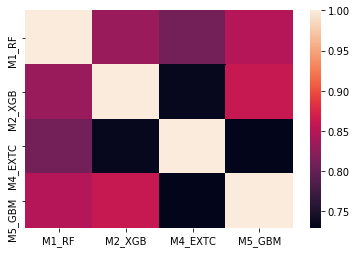

In [237]:
import seaborn as sns
sns.heatmap(train_copy_df[['M1_RF','M2_XGB','M4_EXTC','M5_GBM']].corr())

In [273]:
train_copy_df[['AdoptionSpeed','M1_RF','M2_XGB']]
y_lr = train_copy_df['AdoptionSpeed']
cols = ['M1_RF','M2_XGB','M4_EXTC','M5_GBM']
#cols = ['RescuerID','Age','M1_RF','M2_XGB']
X_lr = train_copy_df[cols]

from sklearn.linear_model import LogisticRegression
#stack_clf = RandomForestClassifier(max_depth=15,max_features='auto', n_estimators=200,random_state=0)

stack_clf = LogisticRegression()
for idx, (train_idx, valid_idx) in enumerate(splits):
    X_train = X_lr.iloc[train_idx]
    y_train = y_lr[train_idx]
    X_val = X_lr.iloc[valid_idx]
    y_val = y_lr[valid_idx]
    stack_clf.fit(X_train,y_train)
    y_pred = stack_clf.predict(X_val)
    print("Fold {}: accuracy = {:.1f}%, kappa = {:.4f}  (no boundary adjustment)".format(idx,
                                100.0*accuracy_score(y_val, y_pred),     
                                cohen_kappa_score(y_val, y_pred, weights='quadratic')))
        
    
# kappa = cohen_kappa_score(y_lr, y_pred_lr, weights='quadratic')
# print("kappa = {:.4f}  (with accuracy = {:.1f}%)".format(kappa,
#                                 100.0*accuracy_score(y_lr, y_pred_lr)))


X_test_lr = test_copy_df[cols]

y_test_pred_lr = stack_clf.predict(X_test_lr)

np.unique(y_test_pred_lr,return_counts=True)

Fold 0: accuracy = 41.2%, kappa = 0.4261  (no boundary adjustment)
Fold 1: accuracy = 40.4%, kappa = 0.4107  (no boundary adjustment)
Fold 2: accuracy = 40.7%, kappa = 0.3979  (no boundary adjustment)
Fold 3: accuracy = 41.6%, kappa = 0.4153  (no boundary adjustment)


(array([1, 2, 3, 4]), array([ 690, 1422,   39, 1797]))

In [162]:
np.unique(y_pred_lr,return_counts=True)

(array([1, 2, 4]), array([2563, 5837, 6593]))

In [152]:
X_test_lr = test_copy_df[['M1_RF','M2_XGB']]

y_test_pred_lr = stack_clf.predict(X_test_lr)

np.unique(y_test_pred_lr,return_counts=True)

(array([1, 2, 3, 4]), array([ 984, 1197,  472, 1295]))

In [ ]:
# This cell calculates and plots the kappa (and MSE) vs the class0 fraction adjustment.
# Note that MSE prefers (lower MSE) a class0 fraction near/at 0,
# whereas kappa prefers (higher kappa) a fraction near 1.
# Then the class0 fraction that gives best training kappa is selected.
train_y = y
df_train = train_copy_df
# Save values of kappa, MSE, and accuracy vs the class0 fraction
kappas = []
mses = []
accurs = []
# fractions to try... (could go larger than 1 if desired.)
cl0fracs = np.array(np.arange(0.01,1.001,0.01))
for cl0frac in cl0fracs:
    boundaries = get_class_bounds(train_y, train_meta, class0_fraction=cl0frac)
    train_meta_ints = assign_class(train_meta, boundaries)
    kappa = cohen_kappa_score(df_train['AdoptionSpeed'], train_meta_ints, weights='quadratic')
    kappas.append(kappa)
    mse = mean_squared_error(df_train['AdoptionSpeed'], train_meta_ints)
    mses.append(mse)
    accur = accuracy_score(df_train['AdoptionSpeed'], train_meta_ints)
    accurs.append(accur)
    
# Use the class0 fraction that gives the highest training kappa
ifmax = np.array(kappas).argmax()
cl0frac = cl0fracs[ifmax]

print("Best kappa for class0 fraction = {:.4f}".format(cl0frac))

In [ ]:
# Can skip the class0_fraction adjustment and plotting cells above;
# can delete those two cells and just uncomment this line:
cl0frac = 1.0

print("Using class0_fraction = {:.4f}, gives boundaries:".format(cl0frac))
boundaries = get_class_bounds(train_y, train_meta, class0_fraction=cl0frac)
print(boundaries)

train_meta_ints = assign_class(train_meta, boundaries)
kappa = cohen_kappa_score(train_y, train_meta_ints, weights='quadratic')

print("Adjusted boundaries give:")
print("kappa = {:.4f}  (with accuracy = {:.1f}%)".format(kappa,
                                100.0*accuracy_score(train_y, train_meta_ints)))

In [105]:
# Confusion Matrix
con_mat = confusion_matrix(train_y, y_pred_lr)

# Look at the number that are on the diagonal (exact agreement)
diag = 0.0
for id in range(5):
    diag += con_mat[id,id]
print("\nConfusion matrix - Columns are prediced 0, predicted 1, etc.\n")
print(con_mat)
print("")
print("\n{2:.2f}% = {0}/{1} are on the diagonal (= accuracy)".format(
        int(diag), con_mat.sum(), 100.0*diag/con_mat.sum()))


Confusion matrix - Columns are prediced 0, predicted 1, etc.

[[ 310   39   23   28   10]
 [  17 2442  344  204   83]
 [  10  307 3097  479  144]
 [   6  175  428 2448  202]
 [   2   55  107  140 3893]]


81.30% = 12190/14993 are on the diagonal (= accuracy)


In [103]:
test_meta_ints = y_test_pred_lr
PetID = test_copy_df['PetID']
testAdoptionSpeed = pd.Series(data=test_meta_ints, name="AdoptionSpeed")
# Preparing data for Submission
Submission = pd.concat([PetID,testAdoptionSpeed],axis=1)
Submission.head(40)

,PetID,AdoptionSpeed
0,378fcc4fc,2
1,73c10e136,4
2,72000c4c5,4
3,e147a4b9f,4
4,43fbba852,4
5,77a490ec9,4
6,28c4b1b13,4
7,d1eada628,4
8,d134dec34,4
9,bcd464bb8,2


In [234]:
test_meta_ints = test_copy_df[['M1_RF','M2_XGB']].apply(lambda x: 0 if x[0] == 0 else x[1],axis=1)
#test_meta_ints.iloc[test_copy_df['M1_RF'] == 0] = test_copy_df[test_copy_df['M1_RF'] == 0]
test_meta_ints.value_counts()

4    1101
2     995
1     913
3     857
0      82
dtype: int64

In [235]:
test_meta_ints = test_copy_df[['M1_RF','M2_XGB']].apply(lambda x: 0 if x[0] == 0 else x[1],axis=1)
PetID = test_copy_df['PetID']
testAdoptionSpeed = pd.Series(data=test_meta_ints, name="AdoptionSpeed")
# Preparing data for Submission
Submission = pd.concat([PetID,testAdoptionSpeed],axis=1)
Submission.head(40)

,PetID,AdoptionSpeed
0,378fcc4fc,1
1,73c10e136,4
2,72000c4c5,4
3,e147a4b9f,4
4,43fbba852,4
5,77a490ec9,4
6,28c4b1b13,4
7,d1eada628,3
8,d134dec34,4
9,bcd464bb8,2


In [236]:
Submission.to_csv("Submission25.csv", index=False)